In [1]:
# !pip install wordcloud

In [2]:
# !pip install -U spacy

In [69]:
import re
import string
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,classification_report
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [70]:
df=pd.read_csv('fake_job_postings.csv')

In [71]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [72]:
df.shape

(17880, 18)

In [73]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [74]:
columns = ['job_id','telecommuting','has_company_logo','has_questions','salary_range','employment_type']
for colu in columns:
    del df[colu]

In [75]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [76]:
df.fillna('',inplace=True)

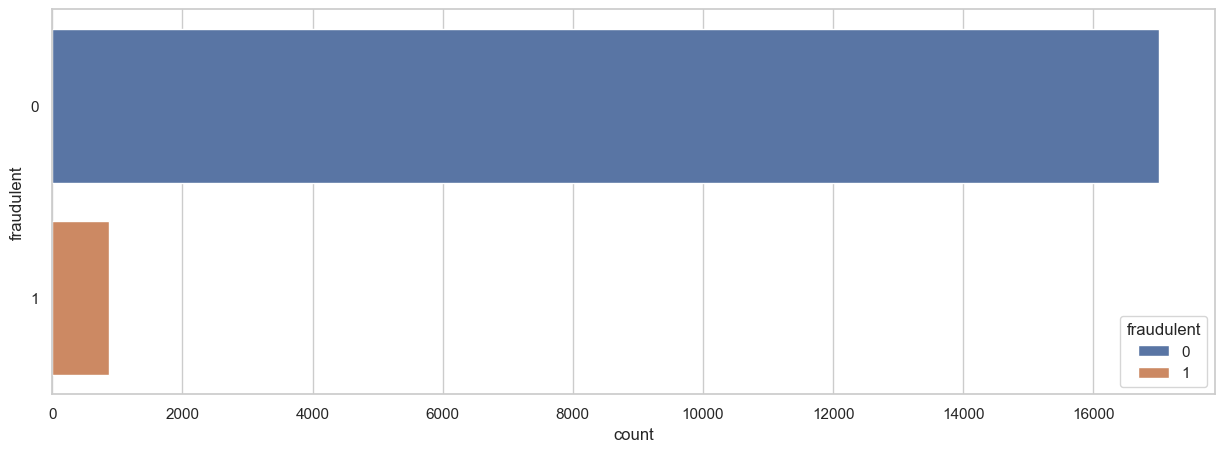

In [77]:
plt.figure(figsize=(15,5))
sns.countplot(y='fraudulent',data=df,hue='fraudulent')
plt.show()

In [78]:
df.groupby('fraudulent')['fraudulent'].count()

fraudulent
0    17014
1      866
Name: fraudulent, dtype: int64

In [79]:
exp = dict(df.required_experience.value_counts())
del exp['']

In [80]:
exp

{'Mid-Senior level': np.int64(3809),
 'Entry level': np.int64(2697),
 'Associate': np.int64(2297),
 'Not Applicable': np.int64(1116),
 'Director': np.int64(389),
 'Internship': np.int64(381),
 'Executive': np.int64(141)}

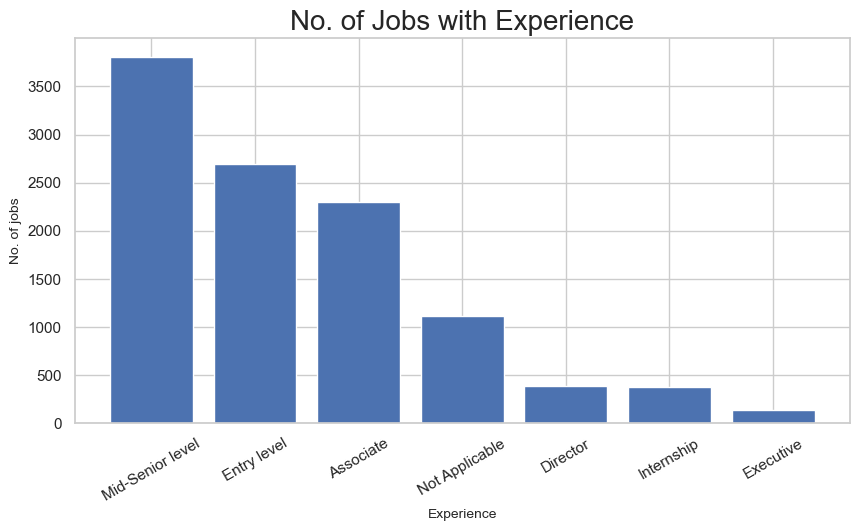

In [81]:
plt.figure(figsize=(10,5))
sns.set_theme(style='whitegrid')
plt.bar(exp.keys(),exp.values())
plt.title('No. of Jobs with Experience',size=20)
plt.xlabel('Experience',size=10)
plt.ylabel('No. of jobs',size=10)
plt.xticks(rotation=30)
plt.show()

In [82]:
def split(location):
    l=location.split(',')
    return l[0]
df['country'] = df.location.apply(split)

In [83]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [84]:
countr = dict(df.country.value_counts()[:14])
del countr['']
countr

{'US': np.int64(10656),
 'GB': np.int64(2384),
 'GR': np.int64(940),
 'CA': np.int64(457),
 'DE': np.int64(383),
 'NZ': np.int64(333),
 'IN': np.int64(276),
 'AU': np.int64(214),
 'PH': np.int64(132),
 'NL': np.int64(127),
 'BE': np.int64(117),
 'IE': np.int64(114),
 'SG': np.int64(80)}

Text(0.5, 0, 'Countries')

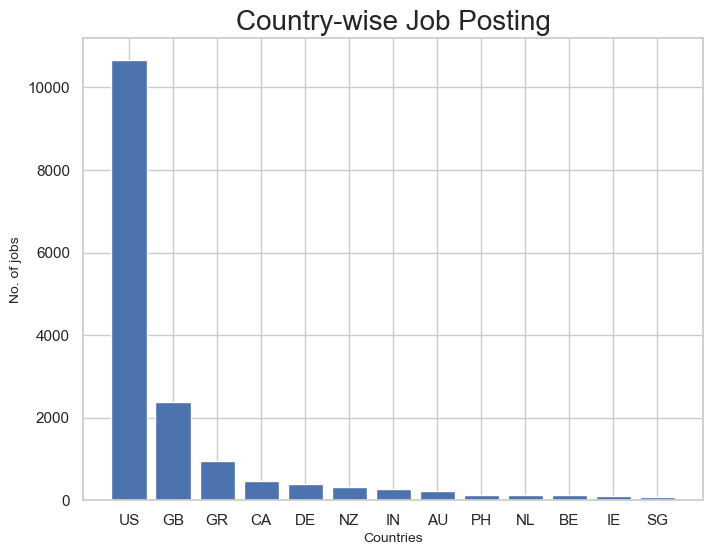

In [85]:
plt.figure(figsize=(8,6))
plt.title('Country-wise Job Posting',size=20)
plt.bar(countr.keys(),countr.values())
plt.ylabel('No. of jobs',size=10)
plt.xlabel('Countries',size=10)

In [86]:
clean = df['required_education'].replace('', np.nan).dropna()
edu = dict(clean.value_counts().head(7))
edu


{"Bachelor's Degree": np.int64(5145),
 'High School or equivalent': np.int64(2080),
 'Unspecified': np.int64(1397),
 "Master's Degree": np.int64(416),
 'Associate Degree': np.int64(274),
 'Certification': np.int64(170),
 'Some College Coursework Completed': np.int64(102)}

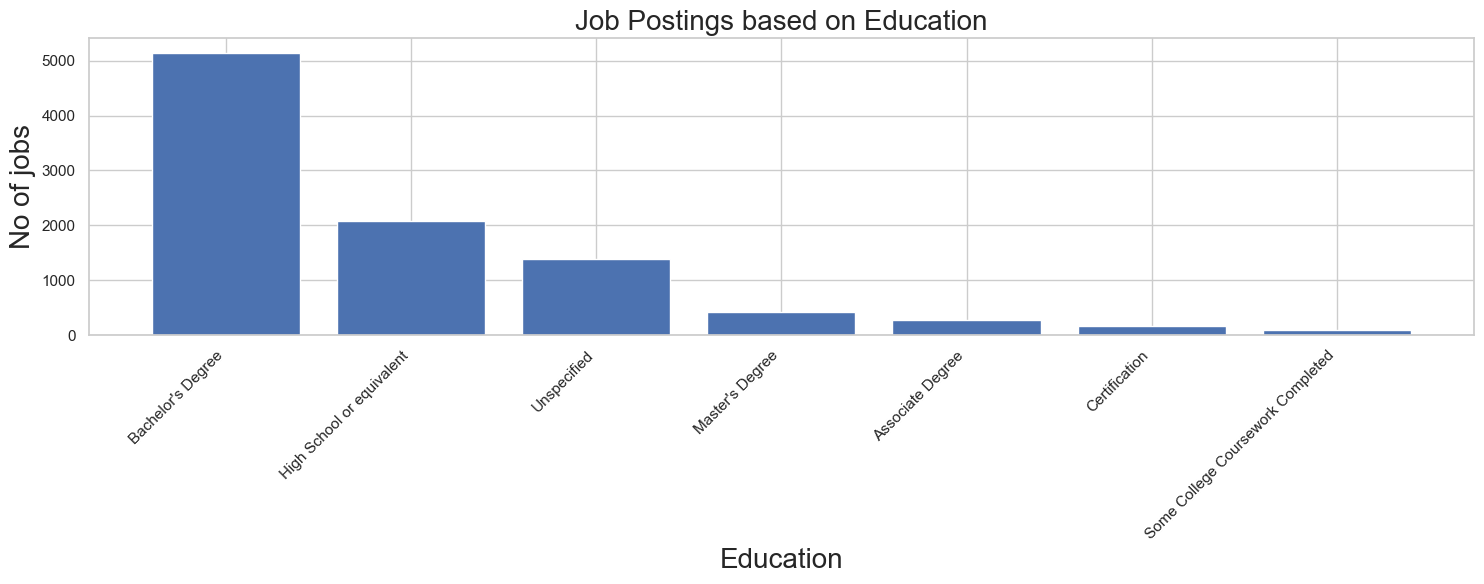

In [87]:
plt.figure(figsize=(15,6))
plt.title('Job Postings based on Education', size=20)

plt.bar(list(edu.keys()), list(edu.values()))

plt.ylabel('No of jobs', size=20)
plt.xlabel('Education', size=20)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [88]:
print(df[df.fraudulent==0].title.value_counts() [:10])

title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Name: count, dtype: int64


In [89]:
print(df[df.fraudulent==1].title.value_counts() [:10])

title
Cruise Staff Wanted *URGENT*                                            21
Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Data Entry Admin/Clerical Positions - Work From Home                    21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Account Sales Managers $80-$130,000/yr                                  10
Payroll Clerk                                                           10
Network Marketing                                                       10
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Name: count, dtype: int64


In [90]:
df['text'] = df['title'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' '+df['benefits']
del df['title']
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']
del df['country']

In [91]:
df.head()

,fraudulent,text
0,0,"Marketing Intern We're Food52, and we've creat..."
1,0,Customer Service - Cloud Video Production 90 S...
2,0,Commissioning Machinery Assistant (CMA) Valor ...
3,0,Account Executive - Washington DC Our passion ...
4,0,Bill Review Manager SpotSource Solutions LLC i...


In [92]:
fraudjobs_text = df[df.fraudulent==1].text
realjobs_text = df[df.fraudulent==0].text

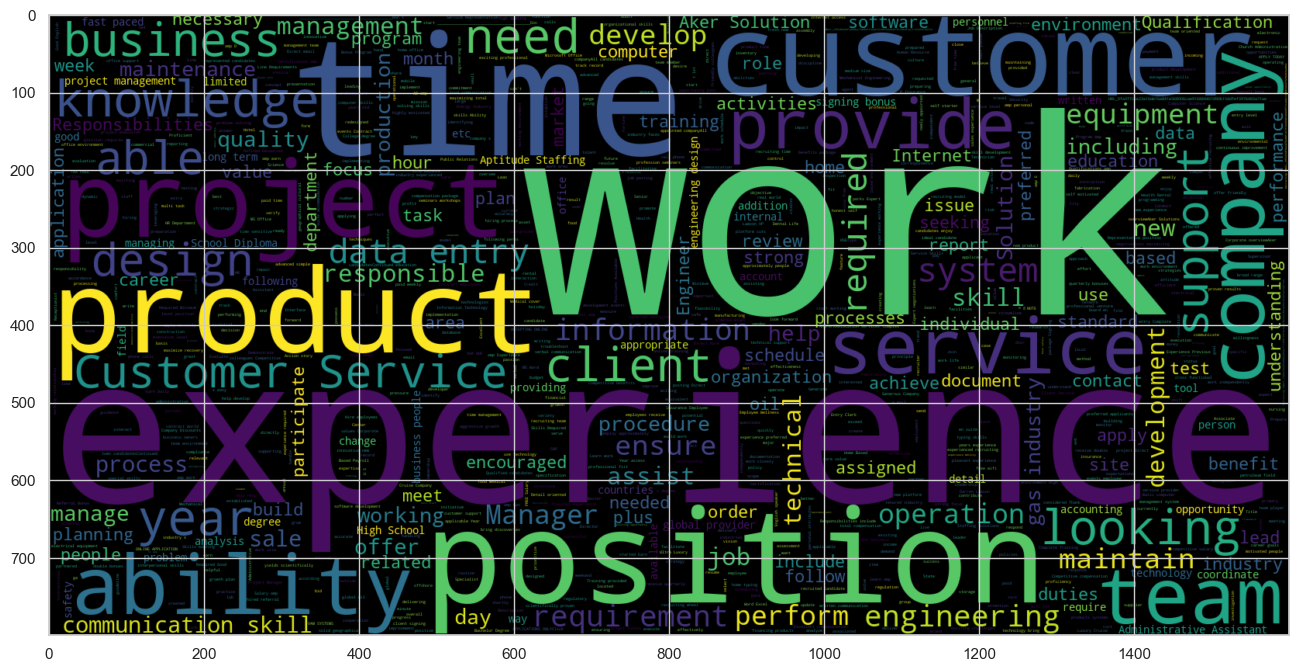

In [93]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc=WordCloud(min_font_size=3, max_words=3000, width = 1600,height = 800, stopwords= STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation='bilinear')

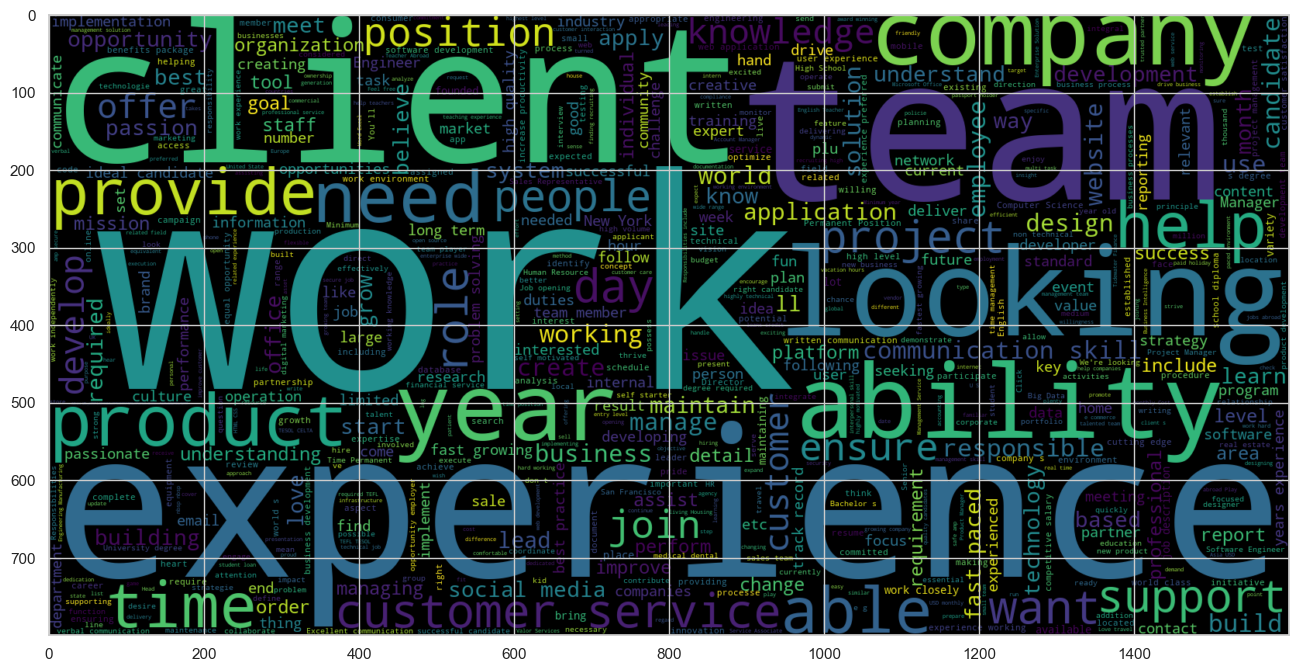

In [95]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc=WordCloud(min_font_size=3, max_words=3000, width = 1600,height = 800, stopwords= STOPWORDS).generate(str(" ".join(realjobs_text)))
plt.imshow(wc,interpolation='bilinear')

In [ ]:
# !pip install spacy && python -m spacy download en

In [96]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS

parser = English()

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    return mytokens

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
     
    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return {}

def clean_text(text):
    return text.strip().lower()


In [97]:
df['text'] = df['text'].apply(clean_text)

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(max_features=100)
x = cv.fit_transform(df['text'])

df1 = pd.DataFrame(x.toarray(), columns=cv.get_feature_names_out())

df.drop(['text'], axis=1, inplace=True)

main_df = pd.concat([df1, df], axis=1)


In [99]:
main_df.head()

,ability,about,all,also,amp,an,and,are,as,at,...,who,will,with,work,working,world,years,you,your,fraudulent
0,0.000000,0.041120,0.000000,0.042424,0.036488,0.000000,0.755238,0.000000,0.078653,0.000000,...,0.000000,0.000000,0.186067,0.051026,0.068029,0.000000,0.000000,0.000000,0.000000,0
1,0.021895,0.094183,0.035394,0.024292,0.041787,0.029771,0.490896,0.056626,0.060050,0.052431,...,0.000000,0.078004,0.165735,0.043827,0.116862,0.099327,0.000000,0.204854,0.130452,0
2,0.000000,0.000000,0.176807,0.000000,0.041749,0.089231,0.397029,0.113149,0.000000,0.000000,...,0.000000,0.062346,0.307512,0.058383,0.000000,0.000000,0.000000,0.094462,0.074476,0
3,0.023267,0.000000,0.018806,0.000000,0.000000,0.094909,0.695542,0.000000,0.031906,0.037144,...,0.023132,0.049735,0.075480,0.046573,0.000000,0.105551,0.019806,0.050236,0.059411,0
4,0.000000,0.000000,0.068009,0.000000,0.040147,0.028602,0.606379,0.081605,0.115386,0.000000,...,0.000000,0.000000,0.159230,0.028071,0.037425,0.000000,0.035814,0.030279,0.107427,0


In [103]:
Y = main_df.iloc[:,-1]
X = main_df.iloc[:,:-1]

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12516, 100)
(5364, 100)
(12516,)
(5364,)


In [104]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=100,criterion='entropy')
model=rfc.fit(X_train,y_train)

In [105]:
X_test

,ability,about,all,also,amp,an,and,are,as,at,...,well,who,will,with,work,working,world,years,you,your
4020,0.000000,0.000000,0.090073,0.000000,0.000000,0.030305,0.523506,0.086465,0.015282,0.088954,...,0.000000,0.044318,0.206452,0.132558,0.074357,0.000000,0.000000,0.018973,0.224574,0.056912
2998,0.000000,0.000000,0.026953,0.073996,0.000000,0.045342,0.747652,0.043122,0.045729,0.000000,...,0.035058,0.165767,0.047521,0.090150,0.022250,0.000000,0.000000,0.028387,0.024000,0.000000
12652,0.034299,0.000000,0.055446,0.000000,0.000000,0.069956,0.457748,0.088708,0.094071,0.054757,...,0.000000,0.000000,0.024440,0.148362,0.183087,0.000000,0.000000,0.029198,0.098743,0.058389
3241,0.042938,0.046176,0.069411,0.047640,0.040975,0.087576,0.550116,0.083288,0.029441,0.068549,...,0.000000,0.042690,0.030595,0.116080,0.057300,0.038197,0.000000,0.036552,0.154516,0.073094
4089,0.000000,0.134079,0.151160,0.069165,0.059488,0.000000,0.399339,0.080614,0.128231,0.049761,...,0.000000,0.061978,0.000000,0.067412,0.124785,0.000000,0.000000,0.000000,0.134600,0.053061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,0.000000,0.000000,0.064895,0.000000,0.000000,0.027292,0.450032,0.285519,0.055051,0.064089,...,0.042204,0.039912,0.057209,0.195350,0.133929,0.071423,0.000000,0.000000,0.375603,0.136677
1544,0.135786,0.000000,0.027438,0.000000,0.000000,0.069236,0.616132,0.043898,0.000000,0.027097,...,0.000000,0.067500,0.096752,0.110126,0.045301,0.030198,0.000000,0.028898,0.000000,0.000000
7030,0.000000,0.000000,0.066671,0.091518,0.000000,0.000000,0.616464,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.089198,0.000000,0.073377,0.000000,0.000000,0.000000,0.000000
5157,0.000000,0.087307,0.065620,0.000000,0.038736,0.055194,0.563404,0.000000,0.055666,0.064804,...,0.000000,0.000000,0.000000,0.153635,0.054170,0.000000,0.046038,0.000000,0.000000,0.000000


In [107]:
pred = rfc.predict(X_test)
score = accuracy_score(y_test,pred)
score

0.9699850857568978

In [110]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report\n")
print(classification_report(y_test, pred))

print("Confusion Matrix\n")
print(confusion_matrix(y_test, pred))


Classification Report

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5105
           1       0.98      0.39      0.55       259

    accuracy                           0.97      5364
   macro avg       0.98      0.69      0.77      5364
weighted avg       0.97      0.97      0.96      5364

Confusion Matrix

[[5103    2]
 [ 159  100]]
